In [1]:
%env CUDA_VISIBLE_DEVICES=1
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_VISIBLE_DEVICES=1
env: CUDA_LAUNCH_BLOCKING=1


In [2]:
import sys
import os
import argparse
import multiprocessing as mp
import platform
import warnings

import cv2
import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

from mmgen.apis import set_random_seed
from mmgen.core import build_metric
from mmgen.datasets import build_dataset
from mmgen.models import build_model
from mmgen.utils import get_root_logger
from lib.apis import evaluate_3d
from lib.datasets import build_dataloader
from lib.datasets.shapenet_srn import ShapeNetSRN
import pickle
import cv2
import matplotlib.pyplot as plt
from mmcv import Config, DictAction

with open("model.pkl", "rb") as f:
    model = pickle.load(f)

srn_dir = "/home/yppatel/csi/nerf/data/cars_test"
data_loader = ShapeNetSRN(srn_dir)

config_fn = "/home/yppatel/csi/nerf/configs/paper_cfgs/ssdnerf_cars_recons1v.py"
cfg = Config.fromfile(config_fn)
model = build_model(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg).to("cuda:0")
model.eval()

2023-07-23 11:11:32,115 - mmgen - INFO - Apply 'timestep_weight' rescale_mode for loss_ddpm_mse. Please make sure the passed weight can be updated by external functions.


DiffusionNeRF(
  (code_activation): TanhCode()
  (decoder): TriPlaneDecoder(
    (dir_encoder): SHEncoder: input_dim=3 degree=4
    (base_net): Sequential(
      (0): Linear(in_features=18, out_features=64, bias=True)
    )
    (base_activation): SiLU()
    (density_net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): TruncExp()
    )
    (dir_net): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
    )
    (color_net): Sequential(
      (0): Linear(in_features=64, out_features=3, bias=True)
      (1): Sigmoid()
    )
  )
  (decoder_ema): TriPlaneDecoder(
    (dir_encoder): SHEncoder: input_dim=3 degree=4
    (base_net): Sequential(
      (0): Linear(in_features=18, out_features=64, bias=True)
    )
    (base_activation): SiLU()
    (density_net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): TruncExp()
    )
    (dir_net): Sequential(
      (0): Linear(in_features=16, out_features=64, b

In [37]:
import copy

for original_data in data_loader:
    break

original_data["cond_poses"] = original_data["cond_poses"].unsqueeze(0)
original_data["cond_intrinsics"] = original_data["cond_intrinsics"].unsqueeze(0)
original_data["cond_imgs"] = original_data["cond_imgs"].unsqueeze(0)

cond_idx = [0,1]
test_idx = [4,5]

# only condition on ONE image
data = copy.deepcopy(original_data)
data["cond_poses"] = original_data["cond_poses"][:,cond_idx[0]:cond_idx[1],...].to("cuda:0")
data["cond_intrinsics"] = original_data["cond_intrinsics"][:,cond_idx[0]:cond_idx[1],...].to("cuda:0")
data["cond_imgs"] = original_data["cond_imgs"][:,cond_idx[0]:cond_idx[1],...].to("cuda:0")

# think this might work?
data["test_poses"] = original_data["cond_poses"][:,test_idx[0]:test_idx[1],...].to("cuda:0")
data["test_intrinsics"] = original_data["cond_intrinsics"][:,test_idx[0]:test_idx[1],...].to("cuda:0")
# data["test_imgs"] = original_data["cond_imgs"][:,test_idx[0]:test_idx[1],...].to("cuda:0")

In [38]:
outputs_dict = model.val_step(data)

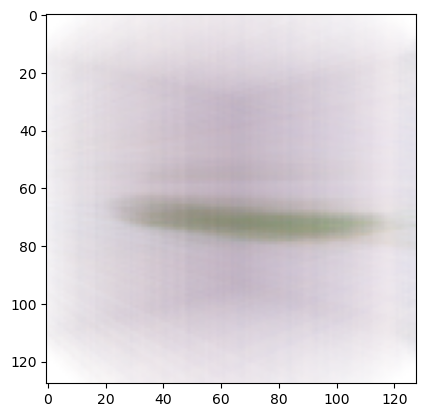

In [44]:
import matplotlib.pyplot as plt
import numpy as np

pred_idx = 0
true_pred_img = original_data["cond_imgs"][0,test_idx[pred_idx],...].cpu().detach().numpy()
test_pred_img = outputs_dict["pred_imgs"][0,pred_idx,...].cpu().detach().numpy()
pred_img = np.transpose(test_pred_img, (1,2,0))

plt.imshow(pred_img)
# plt.imshow(true_pred_img)